导入Inception模型

导入库

In [2]:
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

创建图和会话

In [3]:
graph=tf.Graph()
sess=tf.InteractiveSession(graph=graph)

导入模型

Tensorflow提供了一种以'pb'为扩展名的文件，可以事先把模型导入pb文件中，
在需要的时候导出

In [4]:
model_fn='tensorflow_inception_graph.pb'
#tensorflow_inception_graph.pb文件的下载：
#https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
with tf.gfile.GFile(model_fn,'rb') as f:
    graph_def=tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [5]:
#定义输入图像占位符
t_input=tf.placeholder(np.float32,name='input')
#预处理，因为inception模型训练时对图像减了均值，我们也要
imagenet_mean=117.0#模型训练的均值是117，所以我们减去117，而不是输入图像的均值
#预处理，增加维度
#我们的图像数据格式为（height，width，channels），模型里为了同时输入多张图片而在前面加一维
#变为（batch,height,width,channel)，我们要给我们的图片加一维
t_preprocessed=tf.expand_dims(t_input-imagenet_mean,0)
#0表示维度加在最前面
#导入模型，将处理后的图片送入网络
tf.import_graph_def(graph_def,{'input':t_preprocessed})

找出卷积层

In [6]:
layers=[op.name for op in graph.get_operations()if op.type=='Conv2D']
#输出卷积层数
print('Number of layers:',len(layers))

Number of layers: 59


In [7]:
#输出所有卷积层名字
print(layers)

['import/conv2d0_pre_relu/conv', 'import/conv2d1_pre_relu/conv', 'import/conv2d2_pre_relu/conv', 'import/mixed3a_1x1_pre_relu/conv', 'import/mixed3a_3x3_bottleneck_pre_relu/conv', 'import/mixed3a_3x3_pre_relu/conv', 'import/mixed3a_5x5_bottleneck_pre_relu/conv', 'import/mixed3a_5x5_pre_relu/conv', 'import/mixed3a_pool_reduce_pre_relu/conv', 'import/mixed3b_1x1_pre_relu/conv', 'import/mixed3b_3x3_bottleneck_pre_relu/conv', 'import/mixed3b_3x3_pre_relu/conv', 'import/mixed3b_5x5_bottleneck_pre_relu/conv', 'import/mixed3b_5x5_pre_relu/conv', 'import/mixed3b_pool_reduce_pre_relu/conv', 'import/mixed4a_1x1_pre_relu/conv', 'import/mixed4a_3x3_bottleneck_pre_relu/conv', 'import/mixed4a_3x3_pre_relu/conv', 'import/mixed4a_5x5_bottleneck_pre_relu/conv', 'import/mixed4a_5x5_pre_relu/conv', 'import/mixed4a_pool_reduce_pre_relu/conv', 'import/mixed4b_1x1_pre_relu/conv', 'import/mixed4b_3x3_bottleneck_pre_relu/conv', 'import/mixed4b_3x3_pre_relu/conv', 'import/mixed4b_5x5_bottleneck_pre_relu/conv',

In [23]:
#输出指定卷积层参数
name1='mixed3a_3x3_bottleneck_pre_relu'
print('shape of %s:%s'%(name1,str(graph.get_tensor_by_name('import/'+name1+':0').get_shape())))
name2='mixed5b_5x5_bottleneck_pre_relu'
print('shape of %s:%s'%(name2,str(graph.get_tensor_by_name('import/'+name2+':0').get_shape())))

shape of mixed3a_3x3_bottleneck_pre_relu:(?, ?, ?, 96)
shape of mixed5b_5x5_bottleneck_pre_relu:(?, ?, ?, 48)


2通过单通道特征生成DeepDream图像

In [17]:
#把一个numpy.ndarray保存成图像文件
def savearray(img_array,img_name):
    im=PIL.Image.fromarray(np.uint8(img_array))
    #这个np.uint8是必要的，这是PIL的局限
    im.save(img_name)
    print('img saved:%s'%img_name)
#渲染函数
def render_naive(t_obj,img0,iter_n=20,step=1.0):
    #t_ibj：是layer_output[:,:,:,channel]暨卷积层的某个通道
    #img0:初始图像，噪声图像
    #iter_n:迭代次数
    #step:用于控制每次迭代步长。可以看作学习率
    t_score=tf.reduce_mean(t_obj)
    #t_score是t_obj的平均值
    #由于我们的目标是调整图像使卷积层激活值尽可能大
    #即最大化t_score
    #为达到此目标，可以梯度下降
    #计算t_score对t_input的梯度
    t_grad=tf.gradients(t_score,t_input)[0]
    
    img=img0.copy()
    for i in range(iter_n):
        #在session中计算梯度和t_score
        g,score=sess.run([t_grad,t_score],{t_input:img})
        #对img应用梯度
        #先归一化
        g/=g.std()+1e-8
        #将梯度应用在图像上，step用于控制步长,
        img+=g*step
        print('#',end='')
    print('\n')
    return img
    #保存图片
    #savearray(img,'naive_deepdream.jpg')

不同卷积层，不同通道，单通道多通道，噪声图像与背景图像

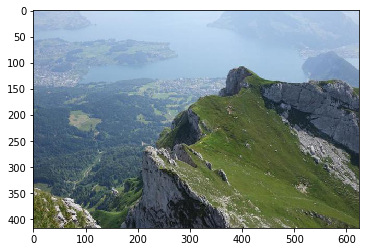

In [10]:
img_noise=PIL.Image.open('mountain.jpg')#背景图像，最好不指定通道
plt.imshow(img_noise)

高层单通道

##############################

##############################

img saved:mountain_h1_1.jpg
img saved:mountain_h1_2.jpg


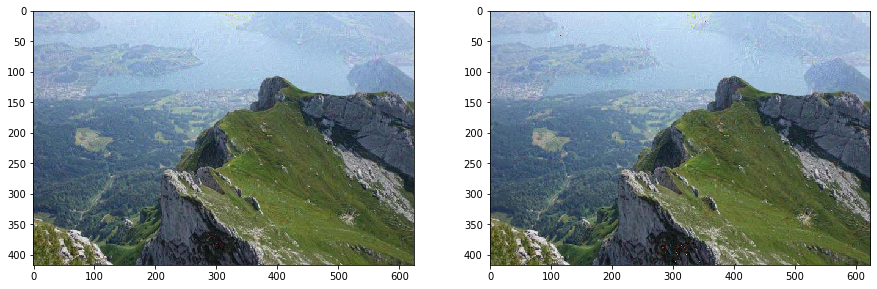

In [25]:
name_h1='mixed5b_5x5_bottleneck_pre_relu'  #(?,?,?,48)高层的卷积层
channel_h1_1=47
channel_h1_2=3
layer_output=graph.get_tensor_by_name("import/%s:0"%name_h1)
img_h1_1=render_naive(layer_output[:,:,:,channel_h1_1],img_noise,iter_n=30)
#该卷积层的139号通道
img_h1_2=render_naive(layer_output[:,:,:,channel_h1_2],img_noise,iter_n=30)
#该卷积层的20号通道
savearray(img_h1_1,'mountain_h1_1.jpg')
savearray(img_h1_2,'mountain_h1_2.jpg')
#保存显示图片
im_h1_1=PIL.Image.open('mountain_h1_1.jpg')
im_h1_2=PIL.Image.open('mountain_h1_2.jpg')
plt.figure(figsize=(15,21))
plt.subplot(1,2,1)
plt.imshow(im_h1_1)
plt.subplot(1,2,2)
plt.imshow(im_h1_2)
plt.show()

低层单通道

看上一个，同一层不同通道区别不大，所以下面我们不进行通道对比

##############################

img saved:mountain_l1.jpg


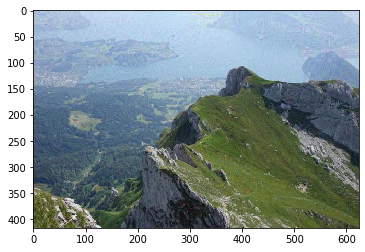

In [26]:
name_l1='mixed3a_3x3_bottleneck_pre_relu'  #(?,?,?,96)低层的卷积层
channel_l1=45
layer_output=graph.get_tensor_by_name("import/%s:0"%name_l1)
img_l1=render_naive(layer_output[:,:,:,channel_l1],img_noise,iter_n=30)
#该卷积层的89号通道
savearray(img_h1_1,'mountain_l1.jpg')
#保存显示图片
im_l1=PIL.Image.open('mountain_l1.jpg')
plt.imshow(im_l1)

高层全通道

单通道效果都不明显

试试全通道

##############################

img saved:mountain_h.jpg


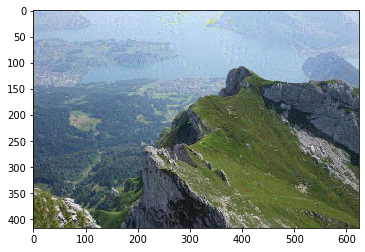

In [27]:
name_h='mixed5b_5x5_bottleneck_pre_relu'  #(?,?,?,48)高层的卷积层
layer_output=graph.get_tensor_by_name("import/%s:0"%name_h)
img_h=render_naive(layer_output,img_noise,iter_n=30)
#该卷积层的所有通道
savearray(img_h,'mountain_h.jpg')
#保存显示图片
im_h=PIL.Image.open('mountain_h.jpg')
plt.imshow(im_h)

效果都不好，试试把图片分解为高低频，分别处理

In [35]:
#调整图像大小
def resize(img,hw):
    min=img.min()
    max=img.max()
    hw=(hw[1],hw[0])
    #高宽是反的，交换一下
    img=(img-min)/(max-min)*255
    im=PIL.Image.fromarray(np.uint8(img))
    img=np.float32(im.resize(hw,PIL.Image.ANTIALIAS))
    img=img/255*(max-min)+min
    return img
#对整张图片求梯度可能太大，将之分为小张处理，默认大小512x512
def calc_grad_tiled(img,t_grad,h,w,tile_size=128):
    sz=tile_size
    h=img.shape[0]
    w=img.shape[1]
    sx,sy=np.random.randint(sz,size=2)
    img_shift=np.roll(np.roll(img,sx,1),sy,0)
    grad=np.zeros_like(img)
    for y in range(0,max(w-sz//22,sz),sz):
        for x in range(0,max(w-sz//2,sz),sz):
            sub=img_shift[y:y+sz,x:x+sz]
            g=sess.run(t_grad,{t_input:sub})
            grad[y:y+sz,x:x+sz]=g
    return np.roll(np.roll(grad,-sx,1),-sy,0)
def render_deepdream(t_obj,img0,
                    iter_n=10,step=1.5,octave_n=4,octave_scale=1.4):
    #octave_n分解的层数,octave_scale层与层之间的倍数关系
    t_score=tf.reduce_mean(t_obj)
    t_grad=tf.gradients(t_score,t_input)[0]
    img=img0.copy()
    #将图像金字塔分解
    #分为高频。低频
    octaves=[]
    for i in range(octave_n-1):
        hw=img.shape[:2]#图像的高和宽
        lo=resize(img,np.int32(np.float32(hw)/octave_scale))
        #lo=img.resize(hw)
        hi=resize(lo,hw)
        #hi=lo.resize(hw)
        img=lo
        octaves.append(hi)
    #先生成低频图像，再依次放大加上高频
    for octave in range(octave_n):
        if octave>0:
            hi=octaves[-octave]
            img=resize(img,hi.shape[:2])+hi
            #img=img.resize(hi.size)+hi
        for i in range(iter_n):
            g=calc_grad_tiled(img,t_grad,81,81)
            img+=g*(step/np.abs(g).mean()+1e-7)
            print('#',end='')
            #print(img.shape)
    img_min=img.min()
    img_max=img.max()
    img=(img-img_min)/(img_max-img_min)*255.
    #处理到0-255，否则可能超255而变成白色
    return img

########################################################################################################################################################################################################img saved:mountain_dream.jpg


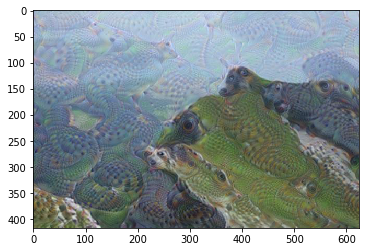

In [39]:
name='mixed4c'
#name='mixed5b_5x5_pre_relu'
layer_output=graph.get_tensor_by_name("import/%s:0"%name)
img0=PIL.Image.open('mountain.jpg')#背景图像，最好不指定通道
img0=np.float32(img0)
img=render_deepdream(layer_output,img0,iter_n=50)#该卷积层的所有通道
savearray(img,'mountain_dream.jpg')
im=PIL.Image.open('mountain_dream.jpg')
plt.imshow(im)